<a href="https://colab.research.google.com/github/bhargav23/EVA4/blob/master/S12/EVA_S12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/drive/My Drive/EVA/S7')

In [0]:
#!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
#! git clone https://github.com/seshuad/IMagenet

In [0]:
#!unzip -q 'tiny-imagenet-200.zip'

In [0]:
import utils
from utils import load_training_images

In [0]:
BATCH_SIZE = 20
NUM_CLASSES = 200
NUM_IMAGES_PER_CLASS = 500
NUM_IMAGES = NUM_CLASSES * NUM_IMAGES_PER_CLASS
TRAINING_IMAGES_DIR = './tiny-imagenet-200/train/'
TRAIN_SIZE = NUM_IMAGES

NUM_VAL_IMAGES = 10000
VAL_IMAGES_DIR = './tiny-imagenet-200/val/'

IMAGE_SIZE = 64
NUM_CHANNELS = 3
IMAGE_ARR_SIZE = IMAGE_SIZE * IMAGE_SIZE * NUM_CHANNELS
training_images, training_labels, training_files = load_training_images(TRAINING_IMAGES_DIR, batch_size=BATCH_SIZE)

In [0]:
import albumentations as A
from evaAlbumentations import AlbumentationTransforms
import numpy as np
import cv2
means = (0.49139968, 0.48215841, 0.44653091)
stdevs = (0.24703223, 0.24348513, 0.26158784)
train_transforms = AlbumentationTransforms(
    [ A.PadIfNeeded(40,40,border_mode=cv2.BORDER_CONSTANT, value=np.array(means)*255),
      A.RandomCrop(32, 32,  always_apply=True),
      A.HorizontalFlip(),
      A.Normalize(mean=means, std=stdevs),
      A.Cutout(num_holes=1, max_h_size=8, max_w_size=8, p=1)])



test_transforms = AlbumentationTransforms([A.Normalize(mean=means, std=stdevs)])

In [0]:
import evadata 
from evadata import TinyImagenetDataset
dataset, class_names = evadata.alldata('./tiny-imagenet-200/')
trainlen = int(len(dataset)*0.7)
train = TinyImagenetDataset(dataset[:trainlen], transform=train_transforms)
test = TinyImagenetDataset(dataset[trainlen:], transform=test_transforms)

In [0]:
import evadataloader
dataloader = evadataloader.DataLoader()

trainloader = dataloader.load(train)
testloader = dataloader.load(test)

Let us show some of the training images, for fun.



In [0]:
import evaresnet
from evaresnet import ResNet18


net = ResNet18(num_classes=len(class_names))

In [11]:
from torchsummary import summary
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = net.to(device)
summary(model, input_size=(3, 64, 64))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1,

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


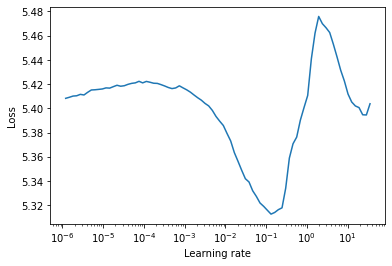

In [13]:
import sys
from torch_lr_finder import LRFinder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, nesterov=True, weight_decay=1e-4)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")
# Plot learning rate vs loss
lr_finder.plot()

# Reset graph
lr_finder.reset()

In [14]:
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
max_lr = lr[loss.index(min(loss))]
max_lr

0.1318256738556408

In [15]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from evascheduler import train,test
from torch.optim.lr_scheduler import OneCycleLR
L1lambda = 0
L2lambda = 0
EPOCHS = 50
model =  net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                 max_lr=0.03,
                 total_steps=51,
                 epochs=51,
                 pct_start=0.2,
                 cycle_momentum=False,
                 base_momentum=0.85,
                 max_momentum=0.95,
                 div_factor=10.,
                 final_div_factor=1e4,
                 last_epoch=-1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch,criterion)
    scheduler.step()
    test(model, device, testloader)


  0%|          | 0/151 [00:00<?, ?it/s]

EPOCH: 0


Loss=4.761862277984619 Batch_id=150 Accuracy=3.11: 100%|██████████| 151/151 [00:48<00:00,  3.09it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.9484, Accuracy: 1704/33000 (5.16%)

EPOCH: 1


Loss=4.573503017425537 Batch_id=150 Accuracy=6.43: 100%|██████████| 151/151 [00:48<00:00,  3.11it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.9268, Accuracy: 2414/33000 (7.32%)

EPOCH: 2


Loss=4.2410430908203125 Batch_id=150 Accuracy=9.53: 100%|██████████| 151/151 [00:49<00:00,  3.07it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.9043, Accuracy: 3158/33000 (9.57%)

EPOCH: 3


Loss=4.09638786315918 Batch_id=150 Accuracy=12.28: 100%|██████████| 151/151 [00:48<00:00,  3.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.8854, Accuracy: 3783/33000 (11.46%)

EPOCH: 4


Loss=3.90431547164917 Batch_id=150 Accuracy=14.86: 100%|██████████| 151/151 [00:48<00:00,  3.10it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.8963, Accuracy: 3422/33000 (10.37%)

EPOCH: 5


Loss=3.872708797454834 Batch_id=150 Accuracy=16.54: 100%|██████████| 151/151 [00:48<00:00,  3.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.8876, Accuracy: 3709/33000 (11.24%)

EPOCH: 6


Loss=3.6072428226470947 Batch_id=150 Accuracy=18.86: 100%|██████████| 151/151 [00:48<00:00,  3.11it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.8461, Accuracy: 5078/33000 (15.39%)

EPOCH: 7


Loss=3.5453124046325684 Batch_id=150 Accuracy=20.74: 100%|██████████| 151/151 [00:48<00:00,  3.11it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.8225, Accuracy: 5858/33000 (17.75%)

EPOCH: 8


Loss=3.572971820831299 Batch_id=150 Accuracy=22.77: 100%|██████████| 151/151 [00:49<00:00,  3.06it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.7709, Accuracy: 7561/33000 (22.91%)

EPOCH: 9


Loss=3.320162773132324 Batch_id=150 Accuracy=24.46: 100%|██████████| 151/151 [00:49<00:00,  3.07it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.7964, Accuracy: 6718/33000 (20.36%)

EPOCH: 10


Loss=3.1170237064361572 Batch_id=150 Accuracy=26.18: 100%|██████████| 151/151 [00:49<00:00,  3.07it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.7316, Accuracy: 8858/33000 (26.84%)

EPOCH: 11


Loss=3.3183345794677734 Batch_id=150 Accuracy=27.64: 100%|██████████| 151/151 [00:49<00:00,  3.06it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.7119, Accuracy: 9506/33000 (28.81%)

EPOCH: 12


Loss=3.2644660472869873 Batch_id=150 Accuracy=29.04: 100%|██████████| 151/151 [00:48<00:00,  3.08it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.7053, Accuracy: 9724/33000 (29.47%)

EPOCH: 13


Loss=2.8472530841827393 Batch_id=150 Accuracy=30.12: 100%|██████████| 151/151 [00:48<00:00,  3.11it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.6874, Accuracy: 10317/33000 (31.26%)

EPOCH: 14


Loss=3.054335355758667 Batch_id=150 Accuracy=31.40: 100%|██████████| 151/151 [00:48<00:00,  3.10it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.6806, Accuracy: 10539/33000 (31.94%)

EPOCH: 15


Loss=3.1222853660583496 Batch_id=150 Accuracy=32.53: 100%|██████████| 151/151 [00:48<00:00,  3.11it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.6942, Accuracy: 10093/33000 (30.58%)

EPOCH: 16


Loss=2.8543310165405273 Batch_id=150 Accuracy=33.45: 100%|██████████| 151/151 [00:48<00:00,  3.10it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.6497, Accuracy: 11559/33000 (35.03%)

EPOCH: 17


Loss=2.732893943786621 Batch_id=150 Accuracy=34.41: 100%|██████████| 151/151 [00:48<00:00,  3.09it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.6426, Accuracy: 11795/33000 (35.74%)

EPOCH: 18


Loss=2.411984443664551 Batch_id=150 Accuracy=35.45: 100%|██████████| 151/151 [00:49<00:00,  3.08it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.6586, Accuracy: 11265/33000 (34.14%)

EPOCH: 19


Loss=2.7466509342193604 Batch_id=150 Accuracy=36.40: 100%|██████████| 151/151 [00:48<00:00,  3.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.6137, Accuracy: 12747/33000 (38.63%)

EPOCH: 20


Loss=2.9090797901153564 Batch_id=150 Accuracy=37.26: 100%|██████████| 151/151 [00:48<00:00,  3.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5995, Accuracy: 13218/33000 (40.05%)

EPOCH: 21


Loss=2.641350746154785 Batch_id=150 Accuracy=38.12: 100%|██████████| 151/151 [00:48<00:00,  3.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.6135, Accuracy: 12756/33000 (38.65%)

EPOCH: 22


Loss=2.6650819778442383 Batch_id=150 Accuracy=38.81: 100%|██████████| 151/151 [00:48<00:00,  3.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5897, Accuracy: 13540/33000 (41.03%)

EPOCH: 23


Loss=2.421462059020996 Batch_id=150 Accuracy=39.97: 100%|██████████| 151/151 [00:48<00:00,  3.11it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5910, Accuracy: 13497/33000 (40.90%)

EPOCH: 24


Loss=2.4416561126708984 Batch_id=150 Accuracy=40.55: 100%|██████████| 151/151 [00:48<00:00,  3.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5805, Accuracy: 13843/33000 (41.95%)

EPOCH: 25


Loss=2.3932957649230957 Batch_id=150 Accuracy=41.41: 100%|██████████| 151/151 [00:48<00:00,  3.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5841, Accuracy: 13724/33000 (41.59%)

EPOCH: 26


Loss=2.436683177947998 Batch_id=150 Accuracy=41.93: 100%|██████████| 151/151 [00:49<00:00,  3.05it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5832, Accuracy: 13754/33000 (41.68%)

EPOCH: 27


Loss=2.337712287902832 Batch_id=150 Accuracy=43.01: 100%|██████████| 151/151 [00:48<00:00,  3.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5428, Accuracy: 15087/33000 (45.72%)

EPOCH: 28


Loss=2.429898738861084 Batch_id=150 Accuracy=43.86: 100%|██████████| 151/151 [00:48<00:00,  3.11it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5507, Accuracy: 14828/33000 (44.93%)

EPOCH: 29


Loss=2.4774367809295654 Batch_id=150 Accuracy=44.48: 100%|██████████| 151/151 [00:48<00:00,  3.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5513, Accuracy: 14806/33000 (44.87%)

EPOCH: 30


Loss=2.1780359745025635 Batch_id=150 Accuracy=45.49: 100%|██████████| 151/151 [00:48<00:00,  3.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5311, Accuracy: 15473/33000 (46.89%)

EPOCH: 31


Loss=2.250295639038086 Batch_id=150 Accuracy=46.46: 100%|██████████| 151/151 [00:48<00:00,  3.10it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5326, Accuracy: 15424/33000 (46.74%)

EPOCH: 32


Loss=2.3324217796325684 Batch_id=150 Accuracy=46.96: 100%|██████████| 151/151 [00:48<00:00,  3.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5283, Accuracy: 15567/33000 (47.17%)

EPOCH: 33


Loss=2.2399744987487793 Batch_id=150 Accuracy=47.65: 100%|██████████| 151/151 [00:48<00:00,  3.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5293, Accuracy: 15532/33000 (47.07%)

EPOCH: 34


Loss=2.051802158355713 Batch_id=150 Accuracy=48.51: 100%|██████████| 151/151 [00:48<00:00,  3.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5096, Accuracy: 16184/33000 (49.04%)

EPOCH: 35


Loss=1.9997514486312866 Batch_id=150 Accuracy=49.23: 100%|██████████| 151/151 [00:48<00:00,  3.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5167, Accuracy: 15950/33000 (48.33%)

EPOCH: 36


Loss=1.819873332977295 Batch_id=150 Accuracy=49.98: 100%|██████████| 151/151 [00:48<00:00,  3.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5012, Accuracy: 16461/33000 (49.88%)

EPOCH: 37


Loss=2.0074853897094727 Batch_id=150 Accuracy=50.94: 100%|██████████| 151/151 [00:48<00:00,  3.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5040, Accuracy: 16369/33000 (49.60%)

EPOCH: 38


Loss=2.0338938236236572 Batch_id=150 Accuracy=51.73: 100%|██████████| 151/151 [00:47<00:00,  3.17it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.4959, Accuracy: 16634/33000 (50.41%)

EPOCH: 39


Loss=2.16084361076355 Batch_id=150 Accuracy=52.60: 100%|██████████| 151/151 [00:47<00:00,  3.15it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.4898, Accuracy: 16837/33000 (51.02%)

EPOCH: 40


Loss=1.7349648475646973 Batch_id=150 Accuracy=53.30: 100%|██████████| 151/151 [00:47<00:00,  3.16it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.4850, Accuracy: 16994/33000 (51.50%)

EPOCH: 41


Loss=1.8396010398864746 Batch_id=150 Accuracy=53.89: 100%|██████████| 151/151 [00:47<00:00,  3.16it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.4804, Accuracy: 17146/33000 (51.96%)

EPOCH: 42


Loss=1.7837001085281372 Batch_id=150 Accuracy=54.58: 100%|██████████| 151/151 [00:47<00:00,  3.16it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.4757, Accuracy: 17301/33000 (52.43%)

EPOCH: 43


Loss=1.9217926263809204 Batch_id=150 Accuracy=54.99: 100%|██████████| 151/151 [00:48<00:00,  3.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.4766, Accuracy: 17273/33000 (52.34%)

EPOCH: 44


Loss=2.0004968643188477 Batch_id=150 Accuracy=55.68: 100%|██████████| 151/151 [00:47<00:00,  3.15it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.4747, Accuracy: 17336/33000 (52.53%)

EPOCH: 45


Loss=1.8986493349075317 Batch_id=150 Accuracy=55.82: 100%|██████████| 151/151 [00:47<00:00,  3.15it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.4752, Accuracy: 17319/33000 (52.48%)

EPOCH: 46


Loss=1.7595384120941162 Batch_id=150 Accuracy=56.06: 100%|██████████| 151/151 [00:48<00:00,  3.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.4736, Accuracy: 17371/33000 (52.64%)

EPOCH: 47


Loss=1.9335050582885742 Batch_id=150 Accuracy=56.53: 100%|██████████| 151/151 [00:47<00:00,  3.17it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.4702, Accuracy: 17483/33000 (52.98%)

EPOCH: 48


Loss=1.5836535692214966 Batch_id=150 Accuracy=56.61: 100%|██████████| 151/151 [00:47<00:00,  3.16it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.4710, Accuracy: 17456/33000 (52.90%)

EPOCH: 49


Loss=1.8853381872177124 Batch_id=150 Accuracy=56.66: 100%|██████████| 151/151 [00:48<00:00,  3.12it/s]



Test set: Average loss: 0.4718, Accuracy: 17430/33000 (52.82%)



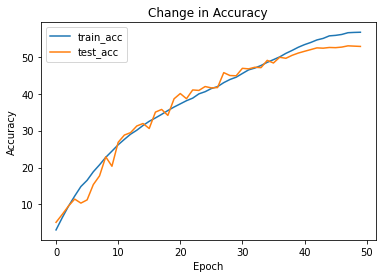

In [16]:
from evascheduler import draw_graph
draw_graph()


In [0]:
from evascheduler import get_misclassified
misclassified = get_misclassified()

In [18]:
import utils
from utils import plot_images
plot_images(misclassified,classes,"misclassified.png")

NameError: ignored

In [0]:
model_save_name = 'models11.pt'
PATH = F"/content/drive/My Drive/EVA/S7/{model_save_name}" 
torch.save(model.state_dict(), PATH)

In [0]:
path = F"/content/drive/My Drive/EVA/S7/{model_save_name}"
model.load_state_dict(torch.load(path))